In [65]:
import pickle
import numpy as np
from scipy.optimize import differential_evolution
import pandas as pd

In [66]:
# Cargar el modelo desde el archivo pickle
with open('model.sav', 'rb') as file:
    modelo = pickle.load(file)


In [67]:
df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv', decimal=',')
target = '% Silica Concentrate'
print(df.shape)
df.drop(['date'], inplace=True, axis=1)

df.head()

import pandas as pd

def eliminar_outliers_iqr(df):
    # Crear una copia del DataFrame para no modificar el original
    df_sin_outliers = df.copy()

    # Iterar sobre cada columna del DataFrame
    for col in df_sin_outliers.columns:
        if df_sin_outliers[col].dtype in ['float64', 'int64']:  # Solo aplicar a columnas numéricas
            # Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
            Q1 = df_sin_outliers[col].quantile(0.25)
            Q3 = df_sin_outliers[col].quantile(0.75)
            IQR = Q3 - Q1  # Rango Intercuartílico

            # Definir los límites inferior y superior para detectar los outliers
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            # Filtrar los valores que no sean outliers
            df_sin_outliers = df_sin_outliers[(df_sin_outliers[col] >= limite_inferior) & (df_sin_outliers[col] <= limite_superior)]

    return df_sin_outliers

df_parsed = df[['% Silica Feed', 'Flotation Column 01 Air Flow', 'Amina Flow',
                'Ore Pulp Flow', 'Ore Pulp pH', 'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow',
                'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level',
                # '% Iron Concentrate',
                 target]]

df_parsed = eliminar_outliers_iqr(df_parsed)

print('Dimensiones de la data original',df.shape)
print('Dimensiones de la data limpia',df_parsed.shape)
df_parsed.head()

(737453, 24)
Dimensiones de la data original (737453, 23)
Dimensiones de la data limpia (601666, 12)


,% Silica Feed,Flotation Column 01 Air Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,16.98,249.214,557.434,395.713,10.0664,253.235,250.576,443.558,502.255,446.370,523.344,1.31
1,16.98,249.719,563.965,397.383,10.0672,250.532,250.862,448.086,496.363,445.922,498.075,1.31
2,16.98,249.741,568.054,399.668,10.0680,247.874,250.313,449.688,484.411,447.826,458.567,1.31
3,16.98,249.917,568.665,397.939,10.0689,254.487,250.049,446.210,471.411,437.690,427.669,1.31
4,16.98,250.203,558.167,400.254,10.0697,252.136,249.895,453.670,462.598,443.682,425.679,1.31


In [68]:
state_features = ['% Silica Feed',  'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH']
control_features = ['Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow',
                'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level']


In [69]:
_lower = dict(df_parsed[control_features].quantile(0.2))
_upper = dict(df_parsed[control_features].quantile(0.8))
control_bounds = {}
for key in control_features:
    _low = _lower[key]
    _high = _upper[key]
    control_bounds[key] = (_low, _high)

control_bounds


{'Flotation Column 01 Air Flow': (249.937, 300.3),
 'Flotation Column 02 Air Flow': (248.995, 301.231),
 'Flotation Column 03 Air Flow': (249.736, 300.683),
 'Flotation Column 04 Level': (351.843, 497.331),
 'Flotation Column 05 Level': (354.242, 497.125),
 'Flotation Column 06 Level': (352.534, 499.613),
 'Flotation Column 07 Level': (352.401, 492.34)}

In [70]:
bounds = [control_bounds[key] for key in control_features]
bounds

[(249.937, 300.3),
 (248.995, 301.231),
 (249.736, 300.683),
 (351.843, 497.331),
 (354.242, 497.125),
 (352.534, 499.613),
 (352.401, 492.34)]

In [71]:
data_to_optimize = df_parsed.sample(50).reset_index(drop=True)
data_to_optimize

,% Silica Feed,Flotation Column 01 Air Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,14.37,299.766,556.717000,401.833000,10.328300,301.041,298.330,366.939000,352.007000,351.537000,344.012000,1.450000
1,6.26,300.248,357.385000,401.645000,9.944300,305.191,297.622,405.859000,398.100000,405.682000,410.820000,1.630000
2,6.26,299.424,526.569000,398.526000,9.841280,250.296,302.183,464.368000,437.760000,502.052000,482.811000,1.040000
3,14.44,249.390,506.037000,392.178000,9.842210,245.783,252.146,357.173000,349.571000,342.147000,361.126000,3.370000
4,17.51,300.164,603.539000,407.405000,9.961480,296.851,298.732,353.106000,348.399000,352.726000,326.733000,2.290000
5,12.28,299.291,492.901000,381.401000,9.049370,295.646,297.222,436.413593,665.807404,588.977963,510.827714,3.758550
6,19.94,299.685,592.471000,402.883000,9.403580,295.204,300.871,262.399000,305.466000,472.031000,424.887000,2.750000
7,6.26,299.075,399.019000,401.738000,10.349900,301.094,298.457,483.854000,389.466000,516.700000,528.490000,1.670000
8,6.26,300.192,325.888489,414.067521,9.675130,300.238,299.632,491.878000,201.596964,531.062000,532.384000,1.130000
9,18.69,250.707,407.105000,399.321000,9.047960,253.113,250.267,380.861000,410.871000,437.680000,391.182000,2.380000


In [72]:
state_features_data = data_to_optimize[state_features]
state_features_data

,% Silica Feed,Amina Flow,Ore Pulp Flow,Ore Pulp pH
0,14.37,556.717000,401.833000,10.328300
1,6.26,357.385000,401.645000,9.944300
2,6.26,526.569000,398.526000,9.841280
3,14.44,506.037000,392.178000,9.842210
4,17.51,603.539000,407.405000,9.961480
5,12.28,492.901000,381.401000,9.049370
6,19.94,592.471000,402.883000,9.403580
7,6.26,399.019000,401.738000,10.349900
8,6.26,325.888489,414.067521,9.675130
9,18.69,407.105000,399.321000,9.047960


In [73]:
import pickle
import numpy as np
from scipy.optimize import differential_evolution

# Función objetivo mejorada que recibe variables de estado y control
def funcion_objetivo(variables_control, variables_estado):
    # Combinar las variables de control y de estado para formar el conjunto completo de features
    features = np.concatenate((variables_estado, variables_control))
    
    # Convertir el vector de features en el formato adecuado para el modelo
    features_array = np.array(features).reshape(1, -1)
    
    # Obtener la predicción del modelo
    prediccion = modelo.predict(features_array)
    
    # Suponiendo que el objetivo es minimizar la predicción
    return prediccion[0]

In [74]:
from tqdm import tqdm
import pandas as pd
from scipy.optimize import differential_evolution

# Función wrapper para la función objetivo
def funcion_objetivo_wrapper(variables_control, variables_estado):
    return funcion_objetivo(variables_control, variables_estado)

# Crear una lista para almacenar los resultados
resultados = []

# Barra de progreso usando tqdm
for idx, row in tqdm(state_features_data.iterrows(), total=state_features_data.shape[0], desc="Optimización en proceso"):
    variables_estado = row.values  # Features de estado para la iteración actual
    
    # Ejecutar el solver de Differential Evolution para minimizar la función objetivo para esta fila
    result = differential_evolution(funcion_objetivo_wrapper, bounds, args=(variables_estado,))
    
    # Guardar los resultados (variables de estado, variables de control optimizadas y el valor objetivo)
    resultado_fila = {
        **{state: variables_estado[i] for i, state in enumerate(state_features)},  # Variables de estado
        **{control: result.x[i] for i, control in enumerate(control_features)},    # Variables de control optimizadas
        'Valor Objetivo': result.fun  # Valor mínimo de la función objetivo
    }
    
    # Agregar el resultado de la fila al listado de resultados
    resultados.append(resultado_fila)

# Convertir la lista de resultados a un DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar el DataFrame de resultados
df_resultados


Optimización en proceso: 100%|██████████| 50/50 [03:24<00:00,  4.10s/it]


,% Silica Feed,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,Valor Objetivo
0,14.37,556.717000,401.833000,10.328300,283.272598,278.838217,300.269132,495.685546,417.670823,394.245322,490.726720,1.196902
1,6.26,357.385000,401.645000,9.944300,263.313024,293.077175,298.100278,492.060909,420.407554,376.549058,353.186390,0.519890
2,6.26,526.569000,398.526000,9.841280,270.908394,288.750920,297.845655,492.001086,416.927579,377.875878,481.277072,0.442934
3,14.44,506.037000,392.178000,9.842210,268.152207,290.951282,296.384588,433.646005,489.657375,353.566599,443.867076,0.583741
4,17.51,603.539000,407.405000,9.961480,265.083912,273.981814,251.737153,359.963440,482.363509,474.283085,443.453047,1.852859
5,12.28,492.901000,381.401000,9.049370,262.625423,262.865575,298.318701,490.089372,428.432776,353.298920,489.712862,1.377272
6,19.94,592.471000,402.883000,9.403580,296.211370,291.350365,250.024850,465.056813,441.182669,474.106024,444.332472,1.126286
7,6.26,399.019000,401.738000,10.349900,278.992862,271.191713,298.069591,492.010396,419.534276,376.030429,353.298927,0.522026
8,6.26,325.888489,414.067521,9.675130,251.568096,293.027405,297.787577,492.297706,494.298814,394.240799,353.527439,0.324208
9,18.69,407.105000,399.321000,9.047960,286.107578,289.113612,250.109836,467.198003,441.144557,436.279178,443.238091,0.435118


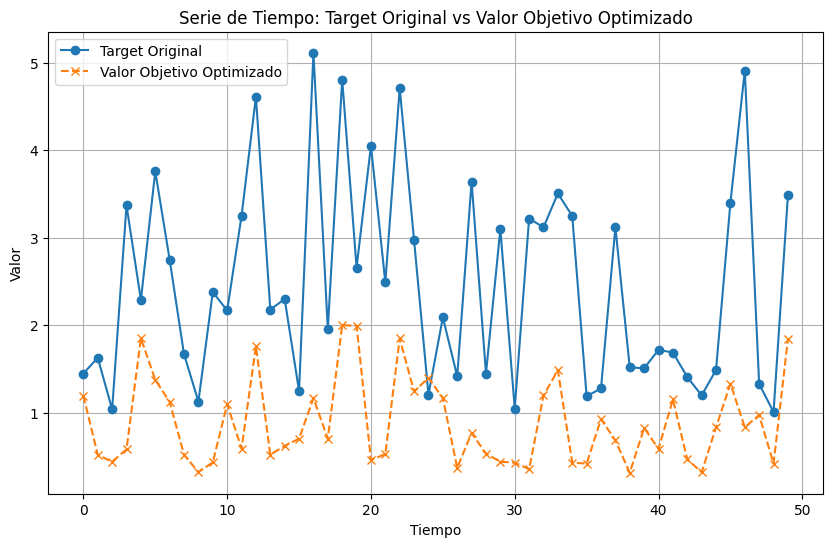

In [75]:
import matplotlib.pyplot as plt

# Suponiendo que data_raw y df_resultados tienen la misma estructura en términos de índices (ej. tiempo o ID)
# Si no, deberás asegurarte de que ambos estén alineados correctamente

# Combinar ambos DataFrames en uno solo por su índice
df_combinado = pd.concat([data_to_optimize[target], df_resultados['Valor Objetivo']], axis=1)

# Renombrar las columnas para mayor claridad
df_combinado.columns = ['Target Original', 'Valor Objetivo Optimizado']

# Crear la serie de tiempo, asumiendo que el índice representa el tiempo o una secuencia
plt.figure(figsize=(10, 6))

# Graficar ambas series de tiempo
plt.plot(df_combinado.index, df_combinado['Target Original'], label='Target Original', linestyle='-', marker='o')
plt.plot(df_combinado.index, df_combinado['Valor Objetivo Optimizado'], label='Valor Objetivo Optimizado', linestyle='--', marker='x')

# Añadir títulos y etiquetas
plt.title('Serie de Tiempo: Target Original vs Valor Objetivo Optimizado')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()


In [76]:
# Asegurarnos de que ambos DataFrames están correctamente combinados como antes
df_combinado = pd.concat([data_to_optimize[target], df_resultados['Valor Objetivo']], axis=1)
df_combinado.columns = ['Target Original', 'Valor Objetivo Optimizado']

# Calcular la diferencia entre el target original y el valor optimizado
df_combinado['Diferencia'] = df_combinado['Target Original'] - df_combinado['Valor Objetivo Optimizado']

# Calcular la media de la diferencia
media_diferencia = df_combinado['Diferencia'].mean()

# Calcular la desviación estándar (std) de la diferencia
std_diferencia = df_combinado['Diferencia'].std()

# Mostrar los resultados
print(f"Media de la diferencia entre el target original y el valor optimizado: {media_diferencia}")
print(f"Desviación estándar de la diferencia: {std_diferencia}")


Media de la diferencia entre el target original y el valor optimizado: 1.581970319367578
Desviación estándar de la diferencia: 1.0362806667301212


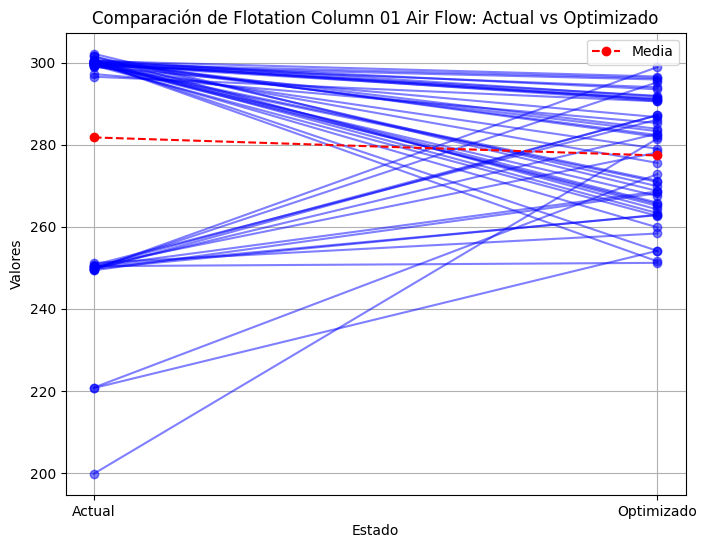

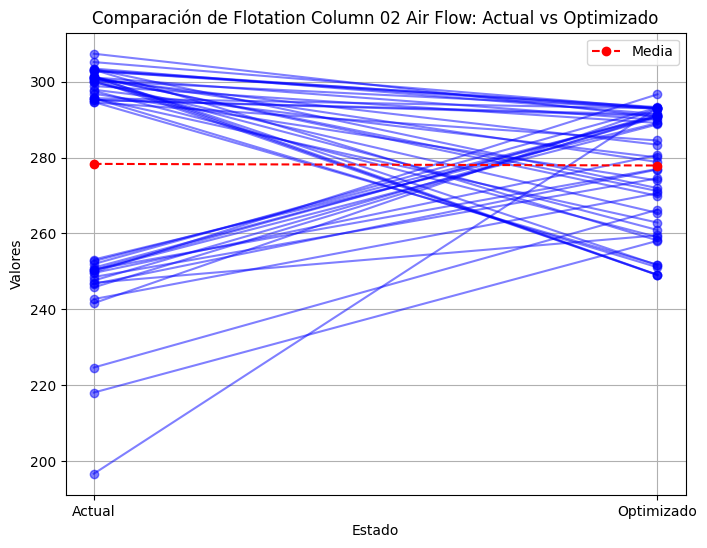

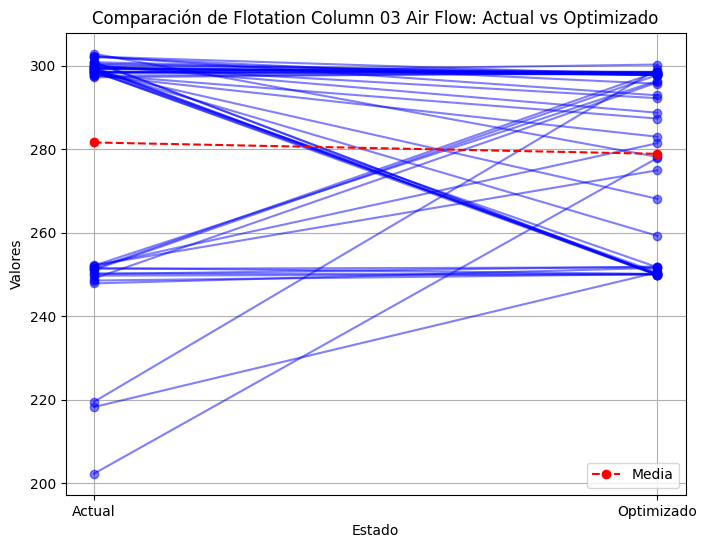

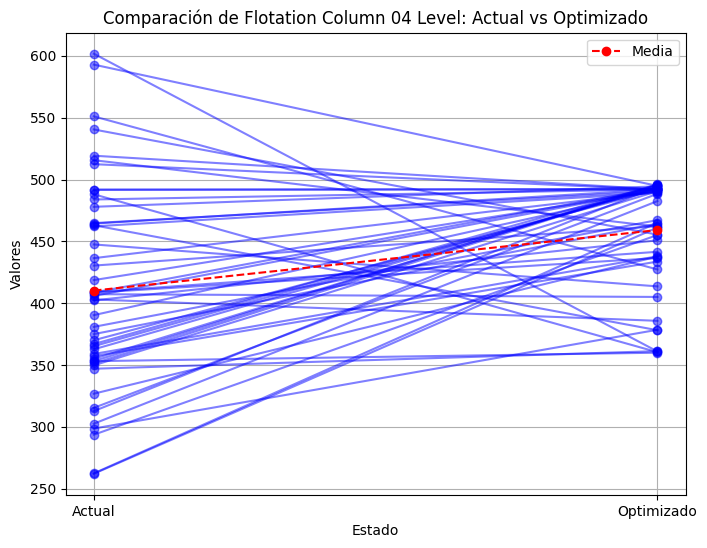

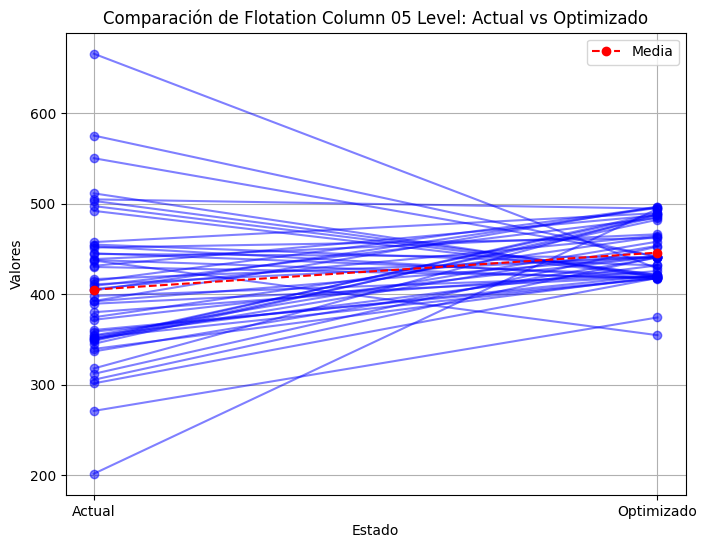

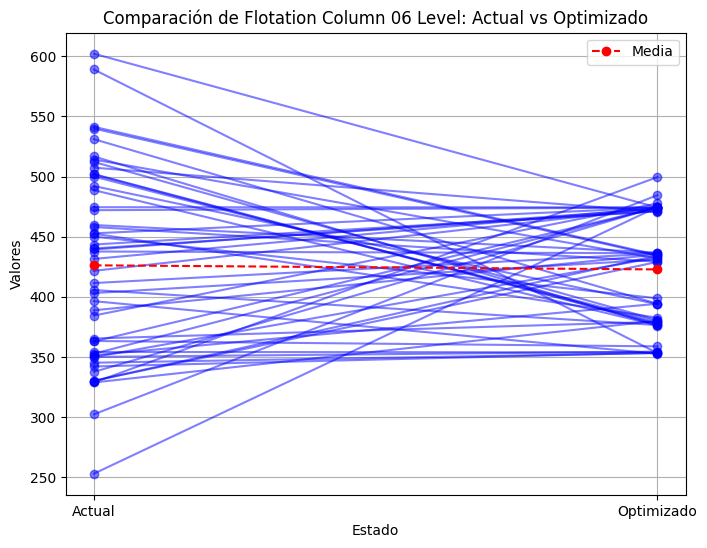

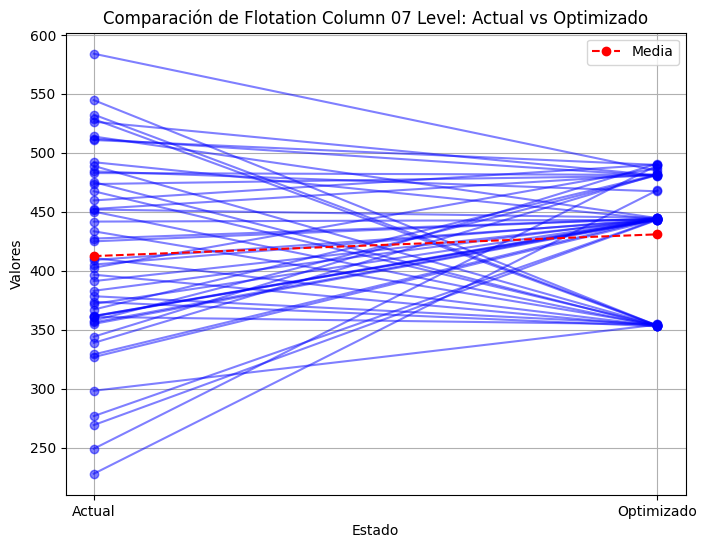

In [77]:
import matplotlib.pyplot as plt

def generate_comparison_plots(total_data: pd.DataFrame, data_optimized: pd.DataFrame, control_features: list):
    """
    Generates line plots showing the shift from each value in total_data to the corresponding
    value in data_optimized for each variable of control.

    Args:
        total_data (pd.DataFrame): DataFrame containing the original data (actual).
        data_optimized (pd.DataFrame): DataFrame containing the optimized data (recommended).
        control_features (list): List of control features to compare.

    Returns:
        None: Displays the plots for each control feature.
    """
    for column in control_features:
        if column in data_optimized.columns and column in total_data.columns:
            plt.figure(figsize=(8, 6))

            # Plot each row: actual vs optimized
            for i in range(total_data.shape[0]):
                actual_value = total_data[column].iloc[i]
                recommended_value = data_optimized[column].iloc[i]

                # Check for NaN values before plotting
                if pd.notna(actual_value) and pd.notna(recommended_value):
                    plt.plot(['Actual', 'Optimizado'], [actual_value, recommended_value], 
                             marker='o', color='blue', alpha=0.5)

            # Plot the line connecting the means of Actual and Optimized
            actual_mean = total_data[column].mean()
            recommended_mean = data_optimized[column].mean()

            plt.plot(['Actual', 'Optimizado'], [actual_mean, recommended_mean], 
                     color='red', linestyle='--', label='Media', marker='o')

            # Customize plot
            plt.title(f"Comparación de {column}: Actual vs Optimizado")
            plt.xlabel("Estado")
            plt.ylabel("Valores")
            plt.grid(True)
            plt.legend()

            # Show the plot
            plt.show()

# Ejecutar la función con tus datos de control
generate_comparison_plots(data_to_optimize, df_resultados, control_features)
